In [2]:
from collections import defaultdict, Counter
from typing import Dict, List, Iterable, Optional, Tuple, Union, Sequence, Callable, NamedTuple

import numpy as np
from typing_extensions import Literal


from gensim.models import KeyedVectors

import mygrad as mg
from mygrad.nnet.initializers import glorot_normal
from mynn.layers import dense
from mygrad.nnet.losses import margin_ranking_loss
from mygrad.typing import ArrayLike

import matplotlib.pyplot as plt

import re
import string

import random

import io


# pip install requests

import requests
from PIL import Image



In [2]:
# coco.py

#  __all__ = ["CocoData"]

class CocoData:
    """Provides convenience functions for querying information from the coco data.
    Also provides functionality for computing IDF-weighted word embeddings based
    on the COCO corpus and a user-provided embedding model (e.g. the glove embeddings)"""

    def __init__(
        self,
        captions_json: Dict[
            Literal["images", "annotations", "info", "licenses"], Union[List, Dict]
        ],
    ):
        # image-ID (int) -> image-URL
        self._image_id_to_url: Dict[int, str] = {
            image["id"]: image["coco_url"] for image in captions_json["images"]
        }

        # image-ID (int) -> all caption-IDs list of ints
        # Note that each image can have multiple captions associated with it
        self._image_id_to_caption_ids: Dict[int, List[int]] = defaultdict(list)
        for a in captions_json["annotations"]:
            self._image_id_to_caption_ids[a["image_id"]].append(a["id"])

        # caption-ID (int) -> caption (str)
        self._caption_id_to_caption: Dict[int, str] = {
            a["id"]: a["caption"] for a in captions_json["annotations"]
        }

        # all image-IDs
        self._image_ids = tuple(sorted(self._image_id_to_url))
        # all caption-IDs
        self._caption_ids = tuple(sorted(self._caption_id_to_caption))

        # Will store: caption-ID -> shape-(D,) embedding
        #
        # The embedding consists of the weighted sum of glove-embeddings for
        # each word in the caption. The weighting is given by the inverse
        # document-frequency for each word
        self._caption_id_to_embedding: Optional[Dict[int, np.ndarray]] = None

        self.embedding_dtype = None
        self.embedding_shape = None

        # Enables us to transform a full query into a single embedding.
        # `self.text_embedder("kids at the zoo") -> shape-(D,) embedding (based on glove & IDF)
        self.text_embedder: Optional[Embedder] = None

    def compute_caption_embeddings(self, model: KeyedVectors):
        """ This method must be run only once, after initializing `CocoData`, to
        compute the embeddings for all of the captions stored here."""
        idf = inverse_document_frequency(self.captions)
        self.text_embedder = Embedder(model, idf)
        self._caption_id_to_embedding: Dict[int, np.ndarray] = {
            _id: self.text_embedder(self.caption_id_to_caption(_id))
            for _id in self.caption_ids
        }
        for v in self._caption_id_to_embedding.values():
            self.embedding_dtype = v.dtype
            self.embedding_shape = v.shape
            break

    def caption_id_to_embedding(self, caption_ids: Union[int, Sequence[int]]) -> np.ndarray:
        """ Returns the word embedding for one or more captions.

        Parameters
        ----------
        caption_ids: Union[int, Sequence[int]]
            One or more caption IDs.

        Returns
        -------
        ndarray, shape-(D,) for one caption, shape-(N, D) for N captions."""
        if self._caption_id_to_embedding is None:
            raise ValueError(
                "You must run `self.compute_caption_embeddings()` before "
                "you can query caption embeddings"
            )
        elif isinstance(caption_ids, int):
            return self._caption_id_to_embedding[caption_ids]
        else:
            vectors = np.zeros(
                (len(caption_ids), self.embedding_shape[0]), dtype=self.embedding_dtype
            )
            for n, _id in enumerate(caption_ids):
                vectors[n] = self._caption_id_to_embedding[_id]
            return vectors

    @property
    def caption_ids(self) -> Tuple[int, ...]:
        """Returns the sorted the caption IDs from the dataset."""
        return self._caption_ids

    @property
    def captions(self) -> Tuple[str, ...]:
        """Returns all of the captions, in order of increasing caption-ID."""
        return tuple(self._caption_id_to_caption[_id] for _id in self.caption_ids)

    @property
    def image_ids(self) -> Tuple[int, ...]:
        """Returns the sorted the image IDs from the dataset"""
        return self._image_ids

    def caption_id_to_caption(self, caption_id: int) -> str:
        """ Returns the caption associated with the specified ID"""
        return self._caption_id_to_caption[caption_id]

    def image_id_to_url(self, image_id: int) -> str:
        """Returns the coco url for the specified image"""
        return self._image_id_to_url[image_id]

    def image_id_to_caption_ids(self, image_id: int) -> List[int]:
        """Returns the caption ids associated with the image"""
        return self._image_id_to_caption_ids[image_id]

    def get_image_captions(self, image_id: int) -> Tuple[str]:
        """Returns a tuple of all the captions associated with the specified image"""
        return tuple(
            self._caption_id_to_caption[cap_id]
            for cap_id in self.image_id_to_caption_ids(image_id)
        )


In [3]:
#model.py

#  __all__ = ["ImageToWord"]


class ImageToWord:
    """A linear encoder network that produces normalized vectors
    in the embedded space"""

    def __init__(self, in_dim: int, out_dim: int):
        self.dense = dense(
            in_dim, out_dim, weight_initializer=glorot_normal, bias=False
        )

    def __call__(self, x: np.ndarray) -> mg.Tensor:
        """
        Parameters
        ----------
        x : numpy.ndarray, shape-(N, C)

        Returns
        -------
        mygrad.Tensor, shape-(N, D)
            The normalized linear projection of each of the N data
        """
        out = self.dense(x)
        return out / mg.sqrt(mg.einsum("ij, ij -> i", out, out)).reshape(-1, 1)

    @property
    def parameters(self) -> Tuple[mg.Tensor, ...]:
        return self.dense.parameters

    def save_model(self, path):
        """Path to .npz file where model parameters will be saved."""
        with open(path, "wb") as f:
            np.savez(f, *(x.data for x in self.parameters))

    def load_model(self, path):
        with open(path, "rb") as f:
            for param, (name, array) in zip(self.parameters, np.load(f).items()):
                param.data[:] = array


In [68]:
# search.py

#  __all__ = ["get_image_embeddings", "generate_database", "create_search_by_text"]


def get_image_embeddings(
    img_ids: Sequence[int], resnet18_features: Dict[int, np.ndarray]
) -> np.ndarray:
    """Returns an array of resnet feature vectors corresponding to the
    supplied image IDs

    Parameters
    ----------
    img_ids : Sequence[int]
        N img IDs

    resnet18_features : Dict[int, np.ndarray]
         img-ID -> shape-(512,) vector

    Returns
    -------
    np.ndarray, shape-(N, 512)"""
    vectors = np.zeros((len(img_ids), 512), dtype=np.float32)
    for n, _id in enumerate(img_ids):
        vectors[n] = resnet18_features[_id]
    return vectors


def generate_database(
    img_ids: Sequence[int],
    model: Callable[[np.ndarray], mg.Tensor],
    resnet18_features: Dict[int, np.ndarray],
    embedding_size: int,
) -> Tuple[np.ndarray, Dict[int, int]]:
    """Given the image_keys of image ids, generate database of vector embeddings.

    Parameters
    ----------
    img_ids : list
        list of image ids

    model : Callable[[numpyndarray], numpy.ndarray]
        Trained network that maps image features to semantic embeddings.

    resnet18_features : Dict[int, numpy.ndarray (1, 512)]
        Dictionary of image id to image features.

    embedding_size: int
        The dimensionality of the embedding produced by the model.

    Returns
    -------
    database: numpy.ndarray, shape=(len(image_keys), 50)
        row of database are embedding vectors for images from image_keys

    row2id: dictionary of row index to image id for database
    """

    database = np.zeros((len(img_ids), embedding_size), dtype=np.float32)

    batch_size = 50

    with mg.no_autodiff:
        for n in range(len(img_ids) // batch_size + 1):
            batch_ids = img_ids[n * batch_size : (n + 1) * batch_size]
            word_embeds = model(get_image_embeddings(batch_ids, resnet18_features))
            database[n * batch_size : (n + 1) * batch_size] = word_embeds.data
    return database, {n: _id for n, _id in enumerate(img_ids)}


def search_images(
    query: np.ndarray,
    database: np.ndarray,
    row2id: Dict[int, int],
    image2url: Callable[[int], str],
    num_hits: int = 6,
):
    """Returns top 6 hits from database of images for the given query.

    Parameters
    ----------
    query : numpy.ndarray, shape=(1, 50)
        Semantic embedding to search against.

    database: numpy.ndarray, shape=(len(image_keys), 50)
        Rows of database are embedding vectors for images from image_keys

    row2id: dictionary of row index to image id for database

    image2url: Callable[[int], str]
        Dictionary of image id to URL.

    num_hits : int
        The number of images to return

    Returns
    -------
    fig, ax: Matplotlib's figure and axes objects.
    """

    scores = np.dot(database, query.T)
    result = np.argsort(scores, axis=0)
    result = result[::-1]

    nrows = np.int32(np.ceil(num_hits / 2))
    ncols = 2
    fig, ax = plt.subplots(nrows, ncols, figsize=(12, 6))

    for i in range(num_hits):
        image_id = row2id[result[i].squeeze().item()]
        img = download_image(image2url(image_id))
        ax[i // 2, i % ncols].imshow(img)
        ax[i // 2, i % ncols].axis("off")

    return fig, ax


def create_search_by_text(
    database: np.ndarray, row2id: Dict[int, int], coco_data: CocoData
) -> Callable[[str, int], Tuple[plt.Figure, plt.Axes]]:
    """Creates a function for searching database easier by encapsulating the query
    semantic-image descriptors, image metadata, and text embedder.

    Parameters
    ----------
    database: numpy.ndarray, shape=(len(image_keys), 50)
        Rows of database are embedding vectors for images from image_keys.

    row2id:  Dict[int, int]
        Dictionary of row index to image id for database.

    coco_data: CocoData

    Returns
    -------
    function(str) --> fig, ax: Matplotlib's figure and axes objects.
        Function that searches database based on text query and returns images for display.
    """

    def search(text: str, num_hits: int = 6) -> Tuple[plt.Figure, plt.Axes]:
        """Searches for and displays images whose contents are
        described by the user-specified caption

        Parameters
        ----------
        text : str
            The user-provided query caption

        num_hits : int, optional (default=8)
            The number of images to return by the search

        Returns
        -------
        Tuple[Figure, Axes]
        """
        return search_images(
            coco_data.text_embedder(text),
            database,
            row2id,
            coco_data.image_id_to_url,
            num_hits=num_hits,
        )

    return search



In [5]:
# text.py

_PUNC_REGEX = re.compile("[{}]".format(re.escape(string.punctuation)))


## __all__ = ["get_words", "inverse_document_frequency"]


def get_words(text: str) -> List[str]:
    """Returns all the words in a string, removing punctuation.

    Parameters
    ----------
    text : str
        The text whose words to return.

    Returns
    -------
    List[str]
        The words in `text`, with no punctuation.
    """

    return _PUNC_REGEX.sub(" ", text.lower()).split()


def _compute_doc_freq(documents: Iterable[str]) -> Counter:
    """Computes document frequency (the "DF" in "TF-IDF").

    Parameters
    ----------
    documents : List(str)
        The list of documents.

    Returns
    -------
    collections.Counter[str, int]
        word -> num-docs that word appeared in
        The dictionary's keys are words and its values are number of documents the word appeared in.
    """

    df = Counter()
    for doc in documents:
        df.update(set(get_words(doc)))

    return df


def inverse_document_frequency(documents: Sequence[str]) -> Dict[str, float]:
    """Computes the inverse document frequency document frequency (the "IDF" in "TF-IDF").

    Parameters
    ----------
    documents : List(str)
        The list of documents.

    Returns
    -------
    collections.Counter[str, int]
        The dictionary's_compute_doc_freq keys are words and its values are number of documents the word appeared in.
    """
    df = _compute_doc_freq(documents)
    return {word: np.log10(len(documents) / count) for word, count in df.items()}


def _get(model, k, value=None, verbose=False):
    try:
        return model[k]
    except KeyError:
        if verbose:
            print(f"'{k}' is not in the word-embedding vocabulary")
        return value


class Embedder:
    """ Stores a word embedder model and IDF table for embedding a document into a single descriptor"""
    def __init__(self, model: KeyedVectors, idf: Dict[str, float]):
        self.model = model
        self.idf = idf

    def __call__(self, text: str) -> np.ndarray:
        """Creates embedding for the provided text (e.g., a caption) by computing
        the IDF-weighted average embedding vector over the words in the caption
        (punctuation is stripped and words are split automatically)

        Parameters
        ----------
        text : str
            The text for which to create an embedding.

        Returns
        -------
        numpy.ndarray, shape=(K,)
            The normalized embedding for `text`, where K is the dimensionality of the base
            word embeddings. The L2 norm of this embedding is 1
        """
        x = sum(_get(self.model, w, 0.0) * self.idf.get(w, 0) for w in get_words(text))
        return x / np.linalg.norm(x)


In [6]:
# training.py

#  __all__ = ["generate_data"]


class TripletIDS(NamedTuple):
    good_caption: int
    good_image: int
    bad_image: int


def get_bad_image_id(
    caption_embedding: np.ndarray,
    good_image_id: int,
    image_ids: Sequence[int],
    coco_data: CocoData,
    tournament_size: int,
) -> int:
    """Picks "hard" bad image for provided good image based on bad image's caption
    being similar to good image's caption. Samples set of possible images, computes similarities,
    and picks highest.

    Parameters
    ----------
    caption_embedding : np.ndarray, shape-(K,)

    good_image_id : int
        id of good image.

    image_ids : list
        list of image keys to sample from.

    coco_data : CocoData
        Stores coco image-caption data, along with IDF-weighted caption embeddings

    tournament_size : int
        number of bad images to sample per triple before selecting "hardest" one based on heuristic.

    Returns
    -------
    int
        id of bad image that is has caption most similar to
    """

    best_score = -1.0
    best_bad_image_id = -1

    for _ in range(tournament_size):
        # find different other image
        bad_image_id = good_image_id
        while bad_image_id == good_image_id:
            bad_image_id = random.choice(image_ids)

        # pick random bad caption
        bad_caption_id = random.choice(coco_data.image_id_to_caption_ids(bad_image_id))

        # embed bad caption
        bad_embedding = coco_data.caption_id_to_embedding(bad_caption_id)
        sim = caption_embedding @ bad_embedding

        if sim > best_score:
            best_score = sim
            best_bad_image_id = bad_image_id

    return best_bad_image_id


def generate_data(
    image_ids: Sequence[int],
    coco_data: CocoData,
    num_good_captions: int,
    triples_per_caption: int = 10,
    tournament_size: int = 25,
) -> List[TripletIDS]:
    """Generates set of triples (good_caption_id, good_image_id, bad_image_id) to use for
    triplet-based loss. The (true) similarity between caption and the "good" image is higher
    than the (true) similarity between the caption and the "bad" image.

    Parameters
    ----------
    image_ids : list
        list of image IDs to sample from.

    coco_data : CocoData
        Stores coco image-caption data, along with IDF-weighted caption embeddings

    num_good_captions : int
        number of good captions to sample

    triples_per_caption : int
        number of triples to generate per good caption.

    tournament_size : int
        number of bad images to sample per triple before selecting "hardest" one based on heuristic.

    Returns
    -------
    triples : list
        list of tuples of (good_caption_id, good_image_id, bad_image_id).
    """

    triples = []

    # generate training data
    for i in range(num_good_captions):
        # pick good image
        good_image_id: int = random.choice(image_ids)

        # pick good caption
        good_caption_id: int = random.choice(
            coco_data.image_id_to_caption_ids(good_image_id)
        )
        good_caption_embedding = coco_data.caption_id_to_embedding(good_caption_id)

        # pick bad images
        for j in range(triples_per_caption):
            bad_image_id = get_bad_image_id(
                caption_embedding=good_caption_embedding,
                good_image_id=good_image_id,
                coco_data=coco_data,
                image_ids=image_ids,
                tournament_size=tournament_size,
            )
            triples.append((good_caption_id, good_image_id, bad_image_id))

    np.random.shuffle(triples)

    return [TripletIDS(*t) for t in triples]


def get_image_embeddings(
    img_ids: Sequence[int], resnet18_features: Dict[int, np.ndarray]
) -> np.ndarray:
    """Given N image IDs, return a corresponding shape-(N, 512) array
    of image-descriptor vectors"""
    vectors = np.zeros((len(img_ids), 512), dtype=np.float32)
    for n, _id in enumerate(img_ids):
        vectors[n] = resnet18_features[_id]
    return vectors


def process_batch(
    batch_triples: List[TripletIDS],
    model: Callable[[ArrayLike], mg.Tensor],
    margin: float,
    coco: CocoData,
    resnet18_features: Dict[int, np.ndarray],
) -> Tuple[mg.Tensor, float]:
    """
    Given N triplets of
        - good-caption ID, good-image ID, bad-image ID

    Embeds the two image descriptors via `model` and uses the `margin_ranking_loss`
    to compare them to the embedding for the caption. This loss encourages the
    embedding for the "good" image to match the caption more closely than the embedding
    for the "bad" image.

    Parameters
    ----------
    batch_triples : List[TripletIDS]
        N triplets of (good-caption ID, good-image ID, bad-image ID)

    model : Callable[[ArrayLike], mg.Tensor]
        Embeds image-descriptor (from resnet) -> caption-space

    margin : float
        The margin used by `margin_ranking_loss`

    coco : CocoData
        Used to retrieve the caption's embedding.

    resnet18_features :
        Used to retrieve the image descriptors.

    Returns
    -------
    margin-ranking-loss, accuracy : Tuple[mg.Tensor, float]
        Accuracy is simply the percentage of the batch for which the good-image
        embeddings are more similar to the captions than are the bad-image embeddings.
    """
    good_caption_ids, good_img_ids, bad_image_ids = list(zip(*batch_triples))

    # Given a batch of N triplets, each of these is a shape-(N, D)
    # tensors, where D is the dimensionality of the word-embedding space.
    #
    # Note that all of these tensors have been L2-normalized (either via the
    # process of creating the caption embedding, or via model.__call__)

    # Embedded captions that accurately describe the N "good" images
    captions = coco.caption_id_to_embedding(good_caption_ids)  # shape-(N, D)

    # Model-encoded descriptors of the N images corresponding to the captions. We want
    # the encoded descriptor of each image to be similar to the embedding for its
    # associated caption.
    # (N, 512) -> (N, D)
    good_images = model(get_image_embeddings(good_img_ids, resnet18_features))

    # Model-encoded descriptors for N "random" images. These should bear no relationship
    # to the captions, so we want each of these "bad" encoded image descriptors to be less
    # similar to the embedded caption that it happened to be paired with for training.
    # (N, 512) -> (N, D)
    bad_images = model(get_image_embeddings(bad_image_ids, resnet18_features))

    # cos-distances between N pairs of good-image embeddings and caption embeddings
    sim_good = mg.einsum("ni,ni -> n", captions, good_images)  # shape-(N,)

    # cos-distances between N pairs of bad-image embeddings and caption embeddings
    sim_bad = mg.einsum("ni,ni -> n", captions, bad_images)  # shape-(N,)

    # We want:
    #      w_caption @ w_good_img >  w_caption @ w_bad_img by at least some margin
    loss = margin_ranking_loss(sim_good, sim_bad, margin=margin, y=1)
    acc = (sim_good.data > sim_bad.data).mean()
    return loss, acc


In [7]:
# utils.py 

#  __all__ = ["download_image"]


def download_image(img_url: str) -> Image:
    """Fetches an image from the web.

    Parameters
    ----------
    img_url : string
        The url of the image to fetch.

    Returns
    -------
    PIL.Image
        The image."""

    response = requests.get(img_url)
    return Image.open(io.BytesIO(response.content))


In [30]:
from pathlib import Path
#import os
import json 

# load COCO metadata
#import os
#fileDir = os.path.dirname(os.path.realpath('__file__'))
#filename = os.path.join(fileDir, 'capstone\LanguageProject_MyGrad\data\captions_train2014.json')

cwd = Path().resolve()
filename = cwd / "capstone\LanguageProject_MyGrad\data\captions_train2014.json"
#print(filename)

with Path(filename).open() as f:
    coco_data = json.load(f)

coco = CocoData(coco_data)


image_info = coco_data["images"][0]

print(image_info["id"])
print(image_info["coco_url"])
print(image_info["height"])
print(image_info["width"])


caption_info = coco_data["annotations"][0]
print(caption_info["id"])
print(caption_info["image_id"])
print(caption_info["caption"])



57870
http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg
480
640
48
318556
A very clean and well decorated empty bathroom


In [31]:
filename2 = cwd / "capstone\LanguageProject_MyGrad\data\glove.6B.200d.txt.w2v"
glove = KeyedVectors.load_word2vec_format(filename2, binary=False)

glove["cat"]

array([ 0.14823  , -0.53152  , -0.25973  , -0.44095  ,  0.38555  ,
       -0.4114   , -0.56649  , -0.024739 , -0.2788   , -0.051034 ,
        0.3704   , -0.20881  , -0.30809  ,  0.3041   , -0.3933   ,
       -0.18335  , -0.59395  ,  0.57039  , -0.16796  ,  0.42368  ,
       -0.048687 ,  0.95404  ,  0.65675  , -0.61759  ,  0.41923  ,
       -0.42904  ,  0.2082   , -0.33186  , -0.0037637, -0.20592  ,
        0.18708  ,  0.06889  , -0.28935  , -0.7552   ,  0.29278  ,
       -0.43407  ,  0.034869 ,  0.081405 , -0.14095  , -0.34705  ,
        0.081686 ,  0.40679  , -0.27834  ,  0.93623  , -0.63422  ,
        0.77979  ,  0.29497  , -0.14873  ,  0.5111   ,  0.96405  ,
       -0.072559 , -0.064779 ,  0.20619  , -0.46259  ,  0.49824  ,
       -0.40328  , -0.92244  ,  0.4663   , -0.39433  ,  0.64215  ,
       -0.062508 , -0.71985  , -0.43478  ,  0.34995  , -0.6297   ,
       -0.21176  , -0.21179  , -0.57816  ,  0.84528  ,  0.097692 ,
        0.22564  , -0.2639   , -0.66842  ,  0.40833  , -0.3509

In [32]:
# Compute the IDFs for the words across the captions and then the embedding for each caption

coco.compute_caption_embeddings(glove)


In [42]:
# Load image descriptor vectors

import pickle

#filename3 = cwd / "capstone\LanguageProject_MyGrad\data\resnet18_features.pkl"

with Path(r'C:/Users/yuduk/language/capstone/LanguageProject_MyGrad/data/resnet18_features.pkl').open('rb') as f3:
    resnet18_features = pickle.load(f3)

In [48]:
image_keys = sorted(resnet18_features.keys())

total_images = len(image_keys)
print(total_images)

train_range = total_images * 4 // 5
np.random.shuffle(image_keys)
train_image_keys = image_keys[:train_range]
valid_image_keys = image_keys[train_range:]

# generate train and validation triples
triples_train = generate_data(train_image_keys, coco, num_good_captions=30000, tournament_size=1)
triples_valid = generate_data(valid_image_keys, coco, num_good_captions=10000, tournament_size=1)

len(triples_train), len(triples_valid)


82612


(300000, 100000)

In [49]:
from mynn.optimizers import SGD

num_epochs = 6
batch_size = 32
margin = 0.25

model = ImageToWord(512, 200)

# The optimizer needs the model parameters so that it can update the weights, so we
# pass those in using our model's parameters attribute. 
optimizer = SGD(model.parameters, learning_rate=1e-3, momentum=0.9)



<IPython.core.display.Javascript object>


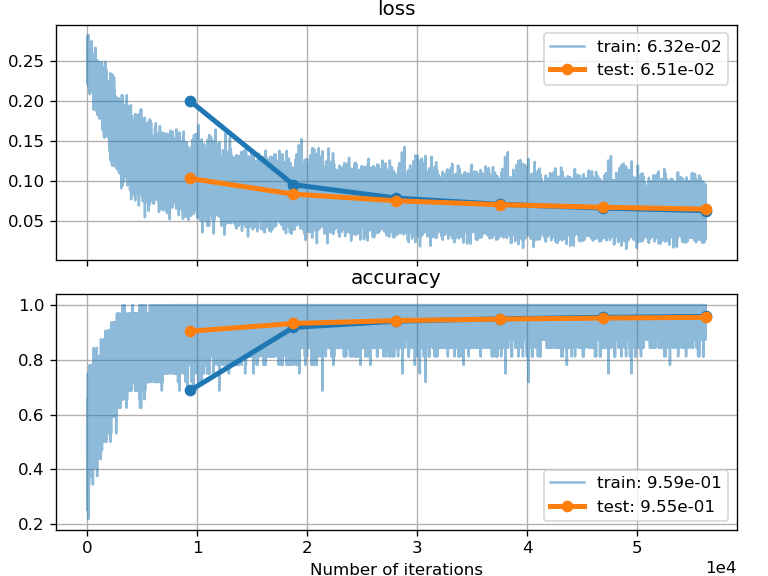

In [50]:
%matplotlib notebook
from noggin import create_plot
plotter, fig, ax = create_plot(["loss", "accuracy"])

In [51]:
for epoch in range(num_epochs):
    for i in range(0, len(triples_train), batch_size):
        loss, acc = process_batch(
            triples_train[i : i + batch_size],
            model,
            margin,
            coco=coco,
            resnet18_features=resnet18_features,
        )

        loss.backward()
        optimizer.step()

        plotter.set_train_batch(
            dict(loss=loss.item(), accuracy=acc),
            batch_size=len(triples_valid[i : i + batch_size]),
        )
        mg.turn_memory_guarding_off()  # slightly speeds up training

    with mg.no_autodiff:
        for i in range(0, len(triples_valid), batch_size):
            loss, acc = process_batch(
                triples_valid[i : i + batch_size],
                model,
                margin,
                coco=coco,
                resnet18_features=resnet18_features,
            )
            plotter.set_test_batch(
                dict(loss=loss.item(), accuracy=acc),
                batch_size=len(triples_valid[i : i + batch_size]),
            )
    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()

In [69]:
database, row2id = generate_database(valid_image_keys, model, resnet18_features, embedding_size=200)
searcher = create_search_by_text(database, row2id, coco)

<IPython.core.display.Javascript object>


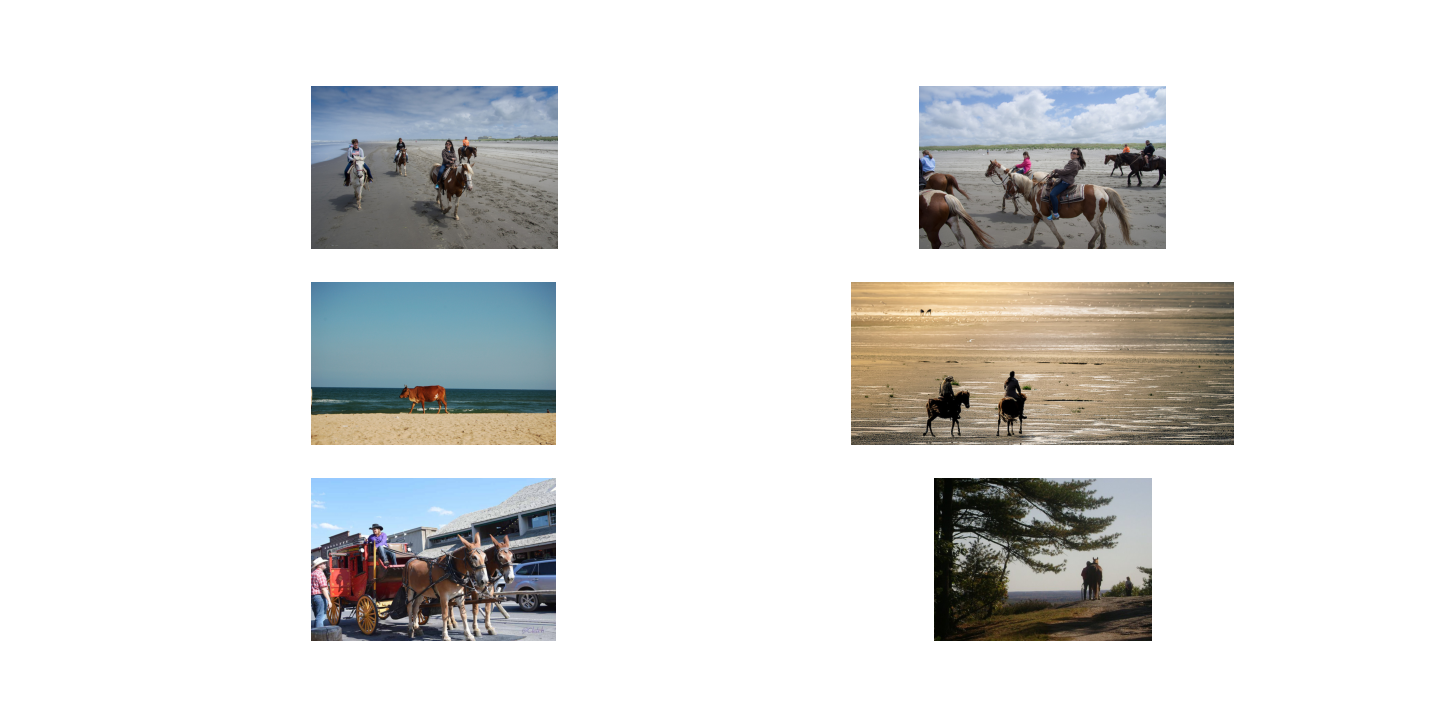

In [70]:
searcher("horses on a beach")

In [54]:
with open("image_embed_model.npy", "wb") as f:
    np.save(f, model.dense.weight.data)

<IPython.core.display.Javascript object>


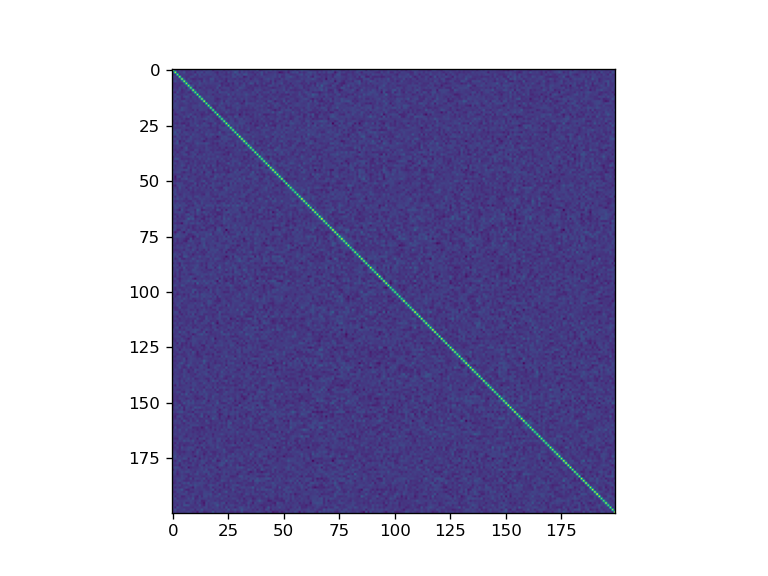

In [55]:
fig, ax = plt.subplots()
W = model.dense.weight.data
ax.imshow(W.T@W)
